In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tabulate
import time
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm

# from torchtext import data
# from torchtext import datasets
# from torchtext.vocab import Vectors, GloVe

import curves
import data
import load_data
import models
import utils

Using TensorFlow backend.


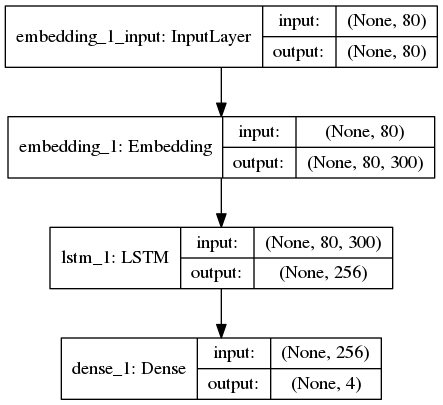

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils.vis_utils import plot_model

batch_size = 1
maxlen = 80

model = Sequential()
model.add(Embedding(135872, 300, input_length=80))
model.add(LSTM(256))
model.add(Dense(4, activation='softmax'))

#K.set_learning_phase(1)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [2]:
print(torch.__version__)

1.0.1


In [3]:
c_dir = 'saved_models/' # training directory

batch_size = 1       # input batch size
num_workers = 4       # number of workers
use_test = False      # switches between validation and test set (default: validation)
model_name = 'LSTMClassifier'  # model name

init_start = './saved_models/point4.pt'     # checkpoint to init start point. metavar='CKPT'
init_end = './saved_models/point5.pt'       # checkpoint to init end point. metavar='CKPT'

fix_start = True      # fix start point
fix_end = True        # fix end point

wd = 1e-5             # weight decay
Momentum = 0.9        # SGD momentum
LR = 1e-3             # initial learning rate
resume = None         # checkpoint to resume training from. metavar='CKPT'
Epochs = 200          # number of epochs to train

save_freq = 2        # save frequency
num_bends = 3         # number of curve bends
curve_type = None     # Bezier/PolyChain
reg = False
init_linear = True    # linear initialization of intermediate points

seed_val = 67          # random seed 

In [4]:
TEXT, vocab_size, num_classes, word_embeddings, train_loader, valid_loader, test_loader = \
                                load_data.load_dataset(batch_size=batch_size)

Length of Text Vocabulary: 135872
Vector size of Text Vocabulary:  torch.Size([135872, 300])
Label Length: 4


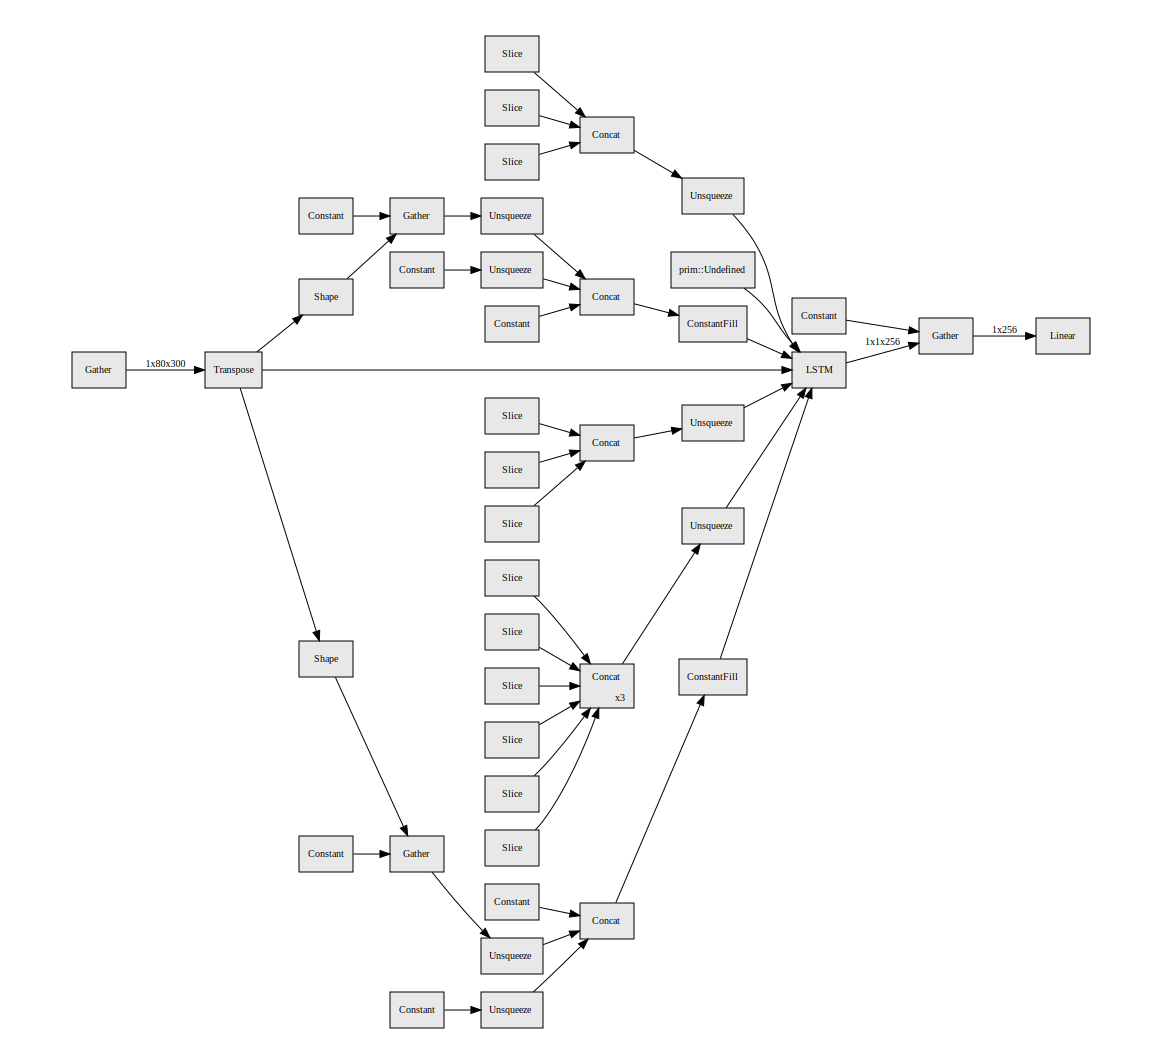

In [5]:
import hiddenlayer as hl
from torchviz import make_dot, make_dot_from_trace

kwargs = {
    'batch_size': batch_size,
    'hidden_size': 256,
    'embedding_length': 300,
    'vocab_size': vocab_size,
    'weights': word_embeddings
}


architecture = getattr(models, model_name)

torch.backends.cudnn.benchmark = True
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)

model = architecture.base(num_classes=num_classes, **kwargs)
model.cuda()
x = Variable(torch.zeros([1,80]).cuda()).long()

with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
#make_dot_from_trace(trace)
hl.build_graph(model, x)
#make_dot(model(x), params=dict(model.named_parameters()))

In [6]:
os.makedirs(c_dir, exist_ok=True)

kwargs = {
    'batch_size': batch_size,
    'hidden_size': 256,
    'embedding_length': 300,
    'vocab_size': vocab_size,
    'weights': word_embeddings
}


architecture = getattr(models, model_name)

torch.backends.cudnn.benchmark = True
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)

if curve_type is None:
    model = architecture.base(num_classes=num_classes, **kwargs)
else:
    curve = getattr(curves, curve_type)
    model = curves.CurveNet(
        num_classes,
        curve,
        architecture.curve,
        num_bends,
        fix_start,
        fix_end,
        architecture_kwargs=kwargs,
    )
    base_model = None
    if resume is None:
        for path, k in [(init_start, 0), (init_end, num_bends - 1)]:
            if path is not None:
                if base_model is None:
                    base_model = architecture.base(num_classes=num_classes, **kwargs)
                checkpoint = torch.load(path)
                print('Loading %s as point #%d' % (path, k))
                base_model.load_state_dict(checkpoint['model_state'])
                model.import_base_parameters(base_model, k)
        if init_linear:
            print('Linear initialization.')
            model.init_linear()
        else:
            print('Quadratic initialization.')
            model.init_quadratic()
model.cuda()
loss_fn = torch.nn.CrossEntropyLoss()


regularizer = None if curve_type is None else curves.l2_regularizer(wd)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

start_epoch = 1
if resume is not None:
    print('Resume training from %s' % resume)
    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])

name = 'LSTMClassifier6'
utils.save_checkpoint(
    c_dir,
    start_epoch - 1,
    name +'_regularizer' if reg else name,
    model_state=model.state_dict(),
    optimizer_state=optimizer.state_dict()
)

for epoch in range(start_epoch, Epochs + 1):
    time_ep = time.time()

#     lr = utils.learning_rate_schedule(LR, epoch, Epochs)
#     utils.adjust_learning_rate(optimizer, lr)
    
    
    train_res = utils.train_model(train_loader, model, optimizer, loss_fn, epoch, batch_size, regularizer)
    val_res = utils.eval_model(valid_loader, model, loss_fn, batch_size, regularizer)

    if epoch % save_freq == 0:
        utils.save_checkpoint(
            c_dir,
            epoch,
            name + '_regularizer' if reg else name,
            model_state=model.state_dict(),
            optimizer_state=optimizer.state_dict()
        )

    time_ep = time.time() - time_ep
    print('Epoch: {:02}, Train Loss: {:.3f}, Train NLL: {:.3f}, Train Acc: {:.2f}%, Val. Loss: {:.3f}, Val. Acc: {:.2f}%'\
         .format(epoch, train_res['loss'], train_res['nll'], train_res['acc'], val_res['nll'], val_res['acc']))


if Epochs % save_freq != 0:
    utils.save_checkpoint(
        c_dir,
        Epochs,
        name + '_regularizer' if reg else name,
        model_state=model.state_dict(),
        optimizer_state=optimizer.state_dict()
    )

/home/hakobtamazyan/venv3/lib/python3.5/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
/home/hakobtamazyan/venv3/lib/python3.5/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)



Epoch: 01, Train Loss: 0.883, Train NLL: 0.883, Train Acc: 59.84%, Val. Loss: 0.361, Val. Acc: 87.28%



Epoch: 02, Train Loss: 0.317, Train NLL: 0.317, Train Acc: 89.24%, Val. Loss: 0.286, Val. Acc: 88.91%



Epoch: 03, Train Loss: 0.266, Train NLL: 0.266, Train Acc: 90.69%, Val. Loss: 0.256, Val. Acc: 90.18%



Epoch: 04, Train Loss: 0.236, Train NLL: 0.236, Train Acc: 91.61%, Val. Loss: 0.242, Val. Acc: 90.48%



Epoch: 05, Train Loss: 0.208, Train NLL: 0.208, Train Acc: 92.57%, Val. Loss: 0.230, Val. Acc: 90.83%



Epoch: 06, Train Loss: 0.185, Train NLL: 0.185, Train Acc: 93.37%, Val. Loss: 0.232, Val. Acc: 91.06%



Epoch: 07, Train Loss: 0.162, Train NLL: 0.162, Train Acc: 94.28%, Val. Loss: 0.235, Val. Acc: 91.08%



Epoch: 08, Train Loss: 0.140, Train NLL: 0.140, Train Acc: 95.09%, Val. Loss: 0.245, Val. Acc: 90.82%



Epoch: 09, Train Loss: 0.117, Train NLL: 0.117, Train Acc: 95.98%, Val. Loss: 0.258, Val. Acc: 90.57%



Epoch: 10, Train Loss: 0.099, Train NLL: 0.099, Train Acc: 96.62%, Val. Loss: 0.296, Val. Acc: 90.57%



Epoch: 11, Train Loss: 0.082, Train NLL: 0.082, Train Acc: 97.27%, Val. Loss: 0.302, Val. Acc: 90.16%



Epoch: 12, Train Loss: 0.071, Train NLL: 0.071, Train Acc: 97.62%, Val. Loss: 0.334, Val. Acc: 90.38%



Epoch: 13, Train Loss: 0.059, Train NLL: 0.059, Train Acc: 98.06%, Val. Loss: 0.347, Val. Acc: 90.40%



Epoch: 14, Train Loss: 0.051, Train NLL: 0.051, Train Acc: 98.33%, Val. Loss: 0.352, Val. Acc: 90.28%



Epoch: 15, Train Loss: 0.044, Train NLL: 0.044, Train Acc: 98.54%, Val. Loss: 0.396, Val. Acc: 90.06%



Epoch: 16, Train Loss: 0.038, Train NLL: 0.038, Train Acc: 98.72%, Val. Loss: 0.395, Val. Acc: 90.01%



Epoch: 17, Train Loss: 0.033, Train NLL: 0.033, Train Acc: 98.90%, Val. Loss: 0.443, Val. Acc: 90.02%



Epoch: 18, Train Loss: 0.031, Train NLL: 0.031, Train Acc: 98.99%, Val. Loss: 0.440, Val. Acc: 90.19%



Epoch: 19, Train Loss: 0.027, Train NLL: 0.027, Train Acc: 99.07%, Val. Loss: 0.418, Val. Acc: 89.90%



Epoch: 20, Train Loss: 0.026, Train NLL: 0.026, Train Acc: 99.08%, Val. Loss: 0.445, Val. Acc: 90.10%



Epoch: 21, Train Loss: 0.023, Train NLL: 0.023, Train Acc: 99.22%, Val. Loss: 0.436, Val. Acc: 90.18%



Epoch: 22, Train Loss: 0.022, Train NLL: 0.022, Train Acc: 99.18%, Val. Loss: 0.442, Val. Acc: 90.13%



Epoch: 23, Train Loss: 0.020, Train NLL: 0.020, Train Acc: 99.25%, Val. Loss: 0.452, Val. Acc: 90.10%



Epoch: 24, Train Loss: 0.019, Train NLL: 0.019, Train Acc: 99.30%, Val. Loss: 0.478, Val. Acc: 90.29%



Epoch: 25, Train Loss: 0.018, Train NLL: 0.018, Train Acc: 99.35%, Val. Loss: 0.467, Val. Acc: 90.23%



Epoch: 26, Train Loss: 0.018, Train NLL: 0.018, Train Acc: 99.34%, Val. Loss: 0.455, Val. Acc: 90.12%



Epoch: 27, Train Loss: 0.017, Train NLL: 0.017, Train Acc: 99.37%, Val. Loss: 0.475, Val. Acc: 90.12%



Epoch: 28, Train Loss: 0.015, Train NLL: 0.015, Train Acc: 99.41%, Val. Loss: 0.485, Val. Acc: 89.35%



Epoch: 29, Train Loss: 0.015, Train NLL: 0.015, Train Acc: 99.39%, Val. Loss: 0.487, Val. Acc: 90.18%



Epoch: 30, Train Loss: 0.014, Train NLL: 0.014, Train Acc: 99.45%, Val. Loss: 0.496, Val. Acc: 90.16%



Epoch: 31, Train Loss: 0.012, Train NLL: 0.012, Train Acc: 99.48%, Val. Loss: 0.531, Val. Acc: 90.17%



Epoch: 32, Train Loss: 0.013, Train NLL: 0.013, Train Acc: 99.47%, Val. Loss: 0.504, Val. Acc: 90.14%



Epoch: 33, Train Loss: 0.013, Train NLL: 0.013, Train Acc: 99.51%, Val. Loss: 0.518, Val. Acc: 90.09%



Epoch: 34, Train Loss: 0.013, Train NLL: 0.013, Train Acc: 99.46%, Val. Loss: 0.517, Val. Acc: 90.10%



Epoch: 35, Train Loss: 0.013, Train NLL: 0.013, Train Acc: 99.48%, Val. Loss: 0.500, Val. Acc: 89.84%



Epoch: 36, Train Loss: 0.011, Train NLL: 0.011, Train Acc: 99.55%, Val. Loss: 0.547, Val. Acc: 89.77%



Epoch: 37, Train Loss: 0.014, Train NLL: 0.014, Train Acc: 99.45%, Val. Loss: 0.533, Val. Acc: 90.15%



Epoch: 38, Train Loss: 0.011, Train NLL: 0.011, Train Acc: 99.54%, Val. Loss: 0.533, Val. Acc: 89.89%



Epoch: 39, Train Loss: 0.011, Train NLL: 0.011, Train Acc: 99.54%, Val. Loss: 0.500, Val. Acc: 90.09%



Epoch: 40, Train Loss: 0.010, Train NLL: 0.010, Train Acc: 99.57%, Val. Loss: 0.498, Val. Acc: 90.00%



Epoch: 41, Train Loss: 0.011, Train NLL: 0.011, Train Acc: 99.55%, Val. Loss: 0.517, Val. Acc: 90.28%



Epoch: 42, Train Loss: 0.009, Train NLL: 0.009, Train Acc: 99.59%, Val. Loss: 0.516, Val. Acc: 90.06%



Epoch: 43, Train Loss: 0.010, Train NLL: 0.010, Train Acc: 99.55%, Val. Loss: 0.554, Val. Acc: 89.79%



Epoch: 44, Train Loss: 0.009, Train NLL: 0.009, Train Acc: 99.61%, Val. Loss: 0.510, Val. Acc: 90.13%



Epoch: 45, Train Loss: 0.010, Train NLL: 0.010, Train Acc: 99.56%, Val. Loss: 0.557, Val. Acc: 89.96%



Epoch: 46, Train Loss: 0.009, Train NLL: 0.009, Train Acc: 99.58%, Val. Loss: 0.565, Val. Acc: 89.81%



Epoch: 47, Train Loss: 0.011, Train NLL: 0.011, Train Acc: 99.55%, Val. Loss: 0.523, Val. Acc: 89.84%


RuntimeError: write(): fd 76 failed with No space left on device

Loading ./saved_models/point4.pt as point #0
Loading ./saved_models/point5.pt as point #2
Linear initialization.


Epoch: 01, Train Loss: 0.191, Train NLL: 0.118, Train Acc: 95.89%, Val. Loss: 0.351, Val. Acc: 89.97%


Epoch: 02, Train Loss: 0.160, Train NLL: 0.088, Train Acc: 96.86%, Val. Loss: 0.347, Val. Acc: 90.62%


Epoch: 03, Train Loss: 0.151, Train NLL: 0.079, Train Acc: 97.21%, Val. Loss: 0.359, Val. Acc: 90.38%


Epoch: 04, Train Loss: 0.139, Train NLL: 0.067, Train Acc: 97.67%, Val. Loss: 0.359, Val. Acc: 90.49%


Epoch: 05, Train Loss: 0.137, Train NLL: 0.067, Train Acc: 97.69%, Val. Loss: 0.387, Val. Acc: 90.12%


Epoch: 06, Train Loss: 0.128, Train NLL: 0.057, Train Acc: 98.02%, Val. Loss: 0.363, Val. Acc: 90.23%


Epoch: 07, Train Loss: 0.122, Train NLL: 0.052, Train Acc: 98.22%, Val. Loss: 0.382, Val. Acc: 90.50%


Epoch: 08, Train Loss: 0.121, Train NLL: 0.050, Train Acc: 98.27%, Val. Loss: 0.392, Val. Acc: 90.63%


Epoch: 09, Train Loss: 0.118, Train NLL: 0.048, Train Acc: 98.27%, Val. Loss: 0.415, Val. Acc: 90.39%


Epoch: 10, Train Loss: 0.115, Train NLL: 0.046, Train Acc: 98.35%, Val. Loss: 0.407, Val. Acc: 90.31%


Epoch: 11, Train Loss: 0.112, Train NLL: 0.044, Train Acc: 98.46%, Val. Loss: 0.401, Val. Acc: 90.60%


Epoch: 12, Train Loss: 0.108, Train NLL: 0.039, Train Acc: 98.63%, Val. Loss: 0.435, Val. Acc: 90.18%


Epoch: 13, Train Loss: 0.106, Train NLL: 0.038, Train Acc: 98.64%, Val. Loss: 0.405, Val. Acc: 90.39%


Epoch: 14, Train Loss: 0.105, Train NLL: 0.037, Train Acc: 98.67%, Val. Loss: 0.413, Val. Acc: 90.37%


Epoch: 15, Train Loss: 0.104, Train NLL: 0.037, Train Acc: 98.67%, Val. Loss: 0.433, Val. Acc: 90.36%


Epoch: 16, Train Loss: 0.103, Train NLL: 0.035, Train Acc: 98.73%, Val. Loss: 0.426, Val. Acc: 90.62%


Epoch: 17, Train Loss: 0.100, Train NLL: 0.032, Train Acc: 98.85%, Val. Loss: 0.433, Val. Acc: 90.25%


Epoch: 18, Train Loss: 0.098, Train NLL: 0.032, Train Acc: 98.83%, Val. Loss: 0.436, Val. Acc: 90.57%


Epoch: 19, Train Loss: 0.098, Train NLL: 0.031, Train Acc: 98.92%, Val. Loss: 0.440, Val. Acc: 90.27%


Epoch: 20, Train Loss: 0.097, Train NLL: 0.030, Train Acc: 98.96%, Val. Loss: 0.455, Val. Acc: 90.27%


Epoch: 21, Train Loss: 0.095, Train NLL: 0.029, Train Acc: 98.93%, Val. Loss: 0.427, Val. Acc: 90.52%


Epoch: 22, Train Loss: 0.094, Train NLL: 0.028, Train Acc: 99.00%, Val. Loss: 0.451, Val. Acc: 90.52%


Epoch: 23, Train Loss: 0.094, Train NLL: 0.027, Train Acc: 99.03%, Val. Loss: 0.443, Val. Acc: 90.45%


Epoch: 24, Train Loss: 0.092, Train NLL: 0.025, Train Acc: 99.10%, Val. Loss: 0.464, Val. Acc: 90.45%


Epoch: 25, Train Loss: 0.092, Train NLL: 0.026, Train Acc: 99.05%, Val. Loss: 0.457, Val. Acc: 90.45%


Epoch: 26, Train Loss: 0.090, Train NLL: 0.024, Train Acc: 99.12%, Val. Loss: 0.470, Val. Acc: 90.68%


Epoch: 27, Train Loss: 0.090, Train NLL: 0.024, Train Acc: 99.11%, Val. Loss: 0.469, Val. Acc: 90.91%


Epoch: 28, Train Loss: 0.089, Train NLL: 0.023, Train Acc: 99.21%, Val. Loss: 0.451, Val. Acc: 90.66%


Epoch: 29, Train Loss: 0.088, Train NLL: 0.022, Train Acc: 99.24%, Val. Loss: 0.453, Val. Acc: 90.54%


Epoch: 30, Train Loss: 0.089, Train NLL: 0.023, Train Acc: 99.18%, Val. Loss: 0.480, Val. Acc: 90.17%


Epoch: 31, Train Loss: 0.089, Train NLL: 0.023, Train Acc: 99.21%, Val. Loss: 0.468, Val. Acc: 90.43%


Epoch: 32, Train Loss: 0.087, Train NLL: 0.023, Train Acc: 99.14%, Val. Loss: 0.458, Val. Acc: 90.61%


Epoch: 33, Train Loss: 0.087, Train NLL: 0.021, Train Acc: 99.20%, Val. Loss: 0.480, Val. Acc: 90.73%


Epoch: 34, Train Loss: 0.087, Train NLL: 0.022, Train Acc: 99.23%, Val. Loss: 0.462, Val. Acc: 90.27%


Epoch: 35, Train Loss: 0.085, Train NLL: 0.020, Train Acc: 99.27%, Val. Loss: 0.483, Val. Acc: 90.57%


Epoch: 36, Train Loss: 0.084, Train NLL: 0.019, Train Acc: 99.32%, Val. Loss: 0.483, Val. Acc: 90.83%


Epoch: 37, Train Loss: 0.085, Train NLL: 0.019, Train Acc: 99.31%, Val. Loss: 0.479, Val. Acc: 90.59%


Epoch: 38, Train Loss: 0.085, Train NLL: 0.019, Train Acc: 99.30%, Val. Loss: 0.511, Val. Acc: 90.35%


Epoch: 39, Train Loss: 0.084, Train NLL: 0.018, Train Acc: 99.34%, Val. Loss: 0.510, Val. Acc: 90.43%


Epoch: 40, Train Loss: 0.083, Train NLL: 0.019, Train Acc: 99.30%, Val. Loss: 0.518, Val. Acc: 90.27%


Epoch: 41, Train Loss: 0.083, Train NLL: 0.018, Train Acc: 99.33%, Val. Loss: 0.489, Val. Acc: 90.13%


Epoch: 42, Train Loss: 0.083, Train NLL: 0.019, Train Acc: 99.31%, Val. Loss: 0.475, Val. Acc: 90.23%


Epoch: 43, Train Loss: 0.083, Train NLL: 0.018, Train Acc: 99.37%, Val. Loss: 0.461, Val. Acc: 90.70%


Epoch: 44, Train Loss: 0.082, Train NLL: 0.018, Train Acc: 99.34%, Val. Loss: 0.509, Val. Acc: 90.21%


KeyboardInterrupt: 

In [27]:
for epoch in np.arange(42,43):
#    name = 'LSTMClassifier4'
    checkpoint = torch.load(os.path.join(c_dir, '%s-%d.pt' % (name, epoch)))
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    regularizer = None if curve_type is None else curves.l2_regularizer(wd)
    
    train_res = utils.eval_model(train_loader, model, loss_fn, batch_size, regularizer)
    val_res = utils.eval_model(valid_loader, model, loss_fn, batch_size, regularizer)
    print('Epoch: {:02}, Train Loss: {:.3f}, Train nll: {:.3f}, Train Acc: {:.2f}%, Val. Loss: {:.3f}, Val. Acc: {:.2f}%'\
          .format(epoch, train_res['loss'], train_res['nll'], train_res['acc'], val_res['nll'], val_res['acc']))
    #print('Epoch: {:02}, Loss: {:.3f}, Acc: {:.2f}%'.format(epoch, res['nll'], res['acc']))

Epoch: 42, Train Loss: 0.450, Train nll: 0.077, Train Acc: 96.87%, Val. Loss: 0.327, Val. Acc: 91.00%


In [17]:
# TEXT, vocab_size, num_classes, word_embeddings, train_loader, valid_loader, test_loader = load_data.load_dataset()
# for i, x in enumerate(train_loader):
#     if i in range(3,7):
#         break
#     print(x.text)

In [18]:
# TEXT, vocab_size, num_classes, word_embeddings, train_loader, valid_loader, test_loader = load_data.load_dataset_imdb()
# for i, x in enumerate(train_loader):
#     if i in range(3,7):
#         break
#     print(x.text)

In [27]:
def train_model(train_loader, model, optimizer, loss_fn, epoch, regularizer=None):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    #optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    
    steps = 0
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, batch in pbar:
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size):# One of the batch returned by BucketIterator has length different than batch_size.
            continue
            
        optimizer.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        if regularizer is not None:
            loss += regularizer(model)

        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        
        loss.backward()
        utils.clip_gradient(model, 1e-2)
        optimizer.step()
        steps += 1
        
#         if steps % 100 == 0:
#             print ('Epoch: {}, Iter: {}, Training Loss: {:.4f}, Training acc: {:.2f}%'\
#                    .format(epoch, i+1, loss.item(), acc.item()))
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        pbar.set_description_str('[TRAIN] Epoch: {}, Train Loss: {:.4f}, Train acc: {:.2f}%'\
            .format(epoch,
                   total_epoch_loss / (i + 1),
                   total_epoch_acc / (i + 1)))
    
    return {
        'loss': total_epoch_loss/len(train_loader),
        'acc': total_epoch_acc/len(train_loader)
    }

def eval_model(val_loader, model, loss_fn, batchregularizer=None):
    total_epoch_loss = 0
    total_epoch_nll = 0
    total_epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_loader), total=len(val_loader)):
            text = batch.text[0]
            if (text.size()[0] is not batch_size):
                continue
                
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            
            nll = loss_fn(prediction, target)
            loss = nll.clone()
            if regularizer is not None:
                loss += regularizer(model)
                
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_nll += nll.item()
            total_epoch_acc += acc.item()

    return {
        'nll': total_epoch_nll/len(val_loader),
        'loss': total_epoch_loss/len(val_loader),
        'acc': total_epoch_acc/len(val_loader)
    }


RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 1)